## Assignment

In this assignment, you'll continue working with the Students Performance in Exams dataset from Kaggle. You should access the data from the Thinkful database. 


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from scipy.stats.mstats import winsorize
from sqlalchemy import create_engine
import warnings
from scipy.stats import jarque_bera
from scipy.stats import normaltest
from scipy.stats import boxcox
from sklearn.preprocessing import normalize
from sklearn.preprocessing import scale

In [3]:
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'studentsperformance'


engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

student_df = pd.read_sql_query('select * from studentsperformance',con=engine)

# no need for an open connection, 
# as we're only doing a single query
engine.dispose()

In [4]:
student_df.info()
student_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


### 1. Are the exam score variables normally distributed? If not, apply a Box-Cox transformation. Does anything change?


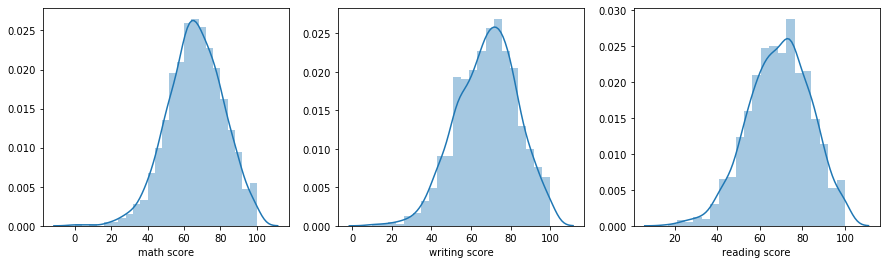

In [5]:
plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
ax1 = sns.distplot(student_df['math score'])

plt.subplot(1,3,2)
ax2 = sns.distplot(student_df['writing score'])

plt.subplot(1,3,3)
ax3 = sns.distplot(student_df['reading score'])

Results look like they may be normally distributed, but let us confirm

In [6]:
for col in ['math score', 'writing score', 'reading score']:
    print(f'Results from normal test for {col}:')
    print(normaltest(student_df[col]))
    print(f'Results for Jargue Bera test for {col}:b')
    print(jarque_bera(student_df[col]))
    print('_'*75)

Results from normal test for math score:
NormaltestResult(statistic=15.408960513931822, pvalue=0.00045080293869937836)
Results for Jargue Bera test for math score:b
(15.912256686712709, 0.0003505075386818213)
___________________________________________________________________________
Results from normal test for writing score:
NormaltestResult(statistic=13.606450837263859, pvalue=0.0011101885439899974)
Results for Jargue Bera test for writing score:b
(13.98509448257235, 0.0009187033894586527)
___________________________________________________________________________
Results from normal test for reading score:
NormaltestResult(statistic=11.11741279628622, pvalue=0.003853758403576582)
Results for Jargue Bera test for reading score:b
(11.383300575987892, 0.0033740202672214448)
___________________________________________________________________________


Based on the stats and p-values, variables are not normal. Let's run the Box Cox:

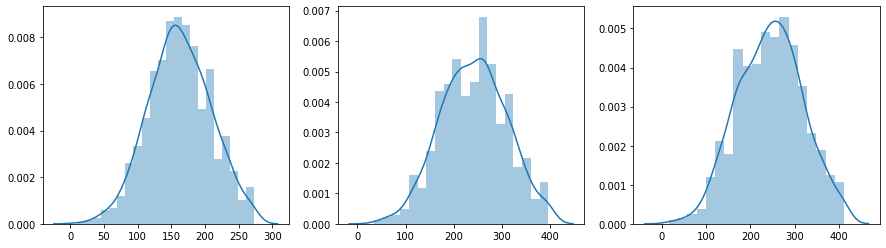

In [7]:
math_boxcox,_ = boxcox(student_df[student_df['math score']>0]['math score'])
reading_boxcox,_ = boxcox(student_df['reading score'])
writing_boxcox,_ = boxcox(student_df['writing score'])

plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
ax4 = sns.distplot(math_boxcox)

plt.subplot(1,3,2)
ax5 = sns.distplot(reading_boxcox)

plt.subplot(1,3,3)
ax6 = sns.distplot(writing_boxcox)

Kurtosis has definitely shortened and yaxis is farther from 1

In [8]:
strings=['math boxcox', 'reading boxcox', 'writing boxcox']
for string, var in zip(strings, [math_boxcox, reading_boxcox, writing_boxcox]):
    print(f'Results from normal test for {string}:')
    print(normaltest(var))
    print(f'Results for Jargue Bera test for {string}:')
    print(jarque_bera(var))
    print('_'*75)

Results from normal test for math boxcox:
NormaltestResult(statistic=1.8323075851586939, pvalue=0.4000547794685686)
Results for Jargue Bera test for math boxcox:
(1.7200982636836308, 0.42314129209599327)
___________________________________________________________________________
Results from normal test for reading boxcox:
NormaltestResult(statistic=5.282274606965809, pvalue=0.07128015626992971)
Results for Jargue Bera test for reading boxcox:
(4.119778573559666, 0.127468081515408)
___________________________________________________________________________
Results from normal test for writing boxcox:
NormaltestResult(statistic=6.267311355052559, pvalue=0.04355827085003712)
Results for Jargue Bera test for writing boxcox:
(4.746478090042761, 0.09317842784043195)
___________________________________________________________________________


Per the Jarque Bera and Normal test, distrubtions are within normal ranges

### 2. Say we want to use a single variable for the exam scores as our target. For this purpose, create a new variable by taking a weighted average of the exam scores. Check whether this new variable is normally distributed. If it's not normally distributed, apply a Box-Cox transformation and check whether or not the transformed variable is normally distributed.


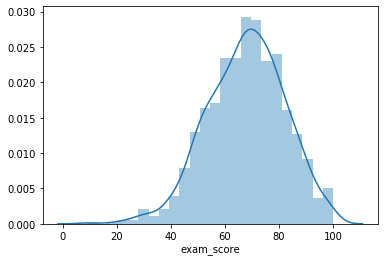

In [13]:
student_df['exam_score'] = (student_df['math score'] + student_df['reading score'] + student_df['writing score'])/3

sns.distplot(student_df['exam_score']);

In [10]:
print(f'Results from normal test for exam score:')
print(normaltest(student_df['exam_score']))
print(f'Results for Jargue Bera test for exam score:')
print(jarque_bera(student_df['exam_score']))

Results from normal test for exam score:
NormaltestResult(statistic=15.186721327231322, pvalue=0.0005037851534494478)
Results for Jargue Bera test for exam score:
(15.453387913085168, 0.00044089934264401887)


The new variable is not normally distributed

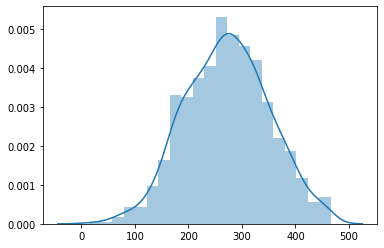

In [14]:
exam_boxcox,_ = boxcox(student_df['exam_score'])

sns.distplot(exam_boxcox);

In [15]:
print(f'Results from normal test for boxcox exam scores:')
print(normaltest(exam_boxcox))
print(f'Results for Jargue Bera test for boxcox exam scores:')
print(jarque_bera(exam_boxcox))

Results from normal test for boxcox exam scores:
NormaltestResult(statistic=2.779857602227616, pvalue=0.24909303914726724)
Results for Jargue Bera test for boxcox exam scores:
(2.4353989331279, 0.2959101356398447)


The Box Cox transformation has worked its magic again

### 3. Which variables seem related to the target variable (the newly created variable in the previous question)? If our goal is to explain the determinants of success in exams, which variables in our dataset might be useful?

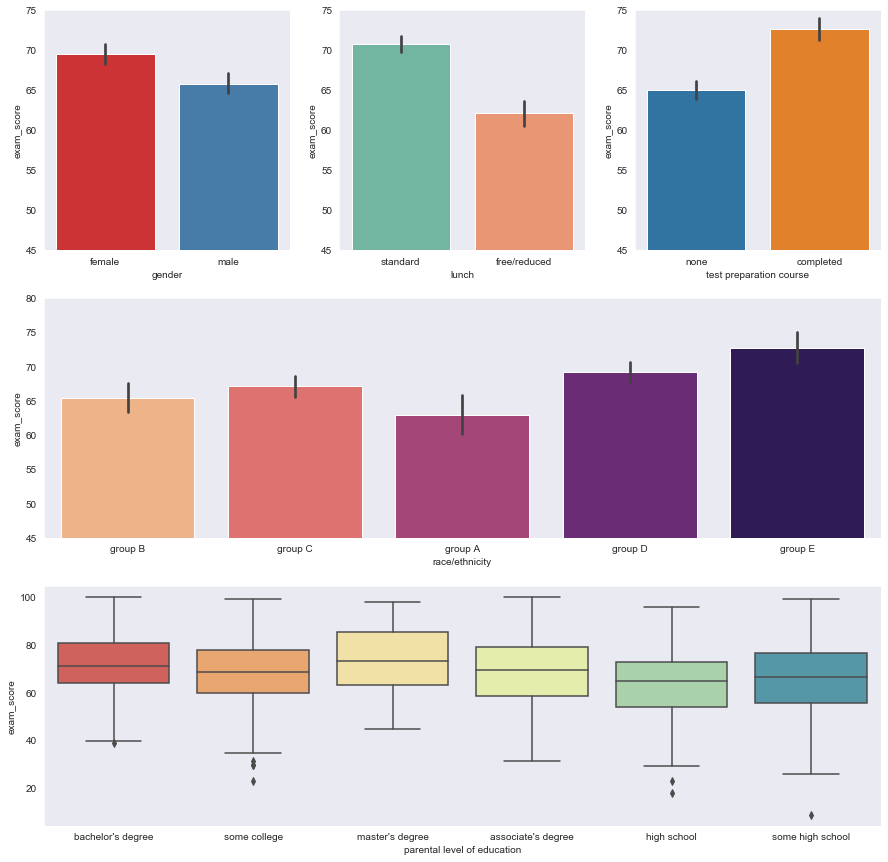

In [69]:
sns.set_style('dark')

normal_dist = sorted(np.random.normal(loc=50, scale=50, size=1000))

fig = plt.figure(figsize=(15,15))

ax1 = plt.subplot2grid((3,3),(0,0))
sns.barplot(x='gender', y='exam_score', data=student_df, palette='Set1', ax=ax1)
ax1.set_ylim(45, 75)

ax2 = plt.subplot2grid((3,3),(0,1))
sns.barplot(x='lunch', y='exam_score', data=student_df, palette='Set2', ax=ax2)
ax2.set_ylim(45, 75)

ax3 = plt.subplot2grid((3,3),(0,2))
sns.barplot(x='test preparation course', y='exam_score', data=student_df, ax=ax3)
ax3.set_ylim(45, 75)

ax4 = plt.subplot2grid((3,3),(1,0), colspan=3)
sns.barplot(y='exam_score', x='race/ethnicity', data=student_df, 
            palette='magma_r', ax=ax4, )
ax4.set_ylim(45, 80)

ax5 = plt.subplot2grid((3,3),(2,0), colspan=3)
_=sns.boxplot(y='exam_score', x='parental level of education', data=student_df,
            palette='Spectral', ax=ax5)

All of the data sets selected above may prove useful as there are the following standouts:

1. Overall females seem to be performing better than males
2. Those on the standard lunch option are seeing a 10-15 point difference. Unlikely this is due to the lunch itself but rather a common factor on both.
3. A completed test prep course is showing about a 5+ point increase
4. Group E's exam scores are higher
5. Parent's having a bachelors or masters also seems to be a factor